# SNRateMetric
By Fabio Ragosta (fabio.ragosta@inaf.it)

Objectives
Find a fraction of correctly classified Sne.

- Simulate SN light curves from known templates.
- Simulate uniform distribution for SN explosion time, position and redshit.
- Estimate the fraction of detected SNe as function of redshift. 
- Estimate the fraction of classified SNe as function of redshift.

Stretch Goals

- Simulate light curves from other templates.
- Estimate the expected SN rate.

In [1]:
import sys, os, h5py, pickle, warnings, subprocess
sys.path.append('/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs') #path where to find the lsst util
from opsimUtils import *

from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial
from lsst.sims.maf.utils import m52snr, radec2pix

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from pylab import cm
import time
from itertools import groupby

#we use PSNID to classify the simulates observedlightcurve, thus we define paths to the SNANA directories
os.environ['SNANA_DIR']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNANA'
os.environ['SNDATA_ROOT']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNDATA_ROOT'
os.environ['LSST_DIR']='./util_snrmetric'
%matplotlib inline

In [2]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))

resultsDb = db.ResultsDb(outDir=outDir)

As an example we have constrained the survey to observe the Sky for 1 yr.

In [3]:
surveyDuration = 1 
init = 1 
sqlconstraint = '( filter= "g" or  filter = "r" or filter="i")'
sqlconstraint+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )
sqlconstraint+=' and proposalId > 1'  #indica a cosa sono riferiti i differenti proposalId

In [4]:
nside = 16
slicer = slicers.HealpixSlicer(nside=nside)
pixelarea = hp.nside2pixarea(nside,degrees=True)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [5]:
from SNclassification_metric import SNclassification_metric, template_lc, getDataMetric 

## Observer light curves from SN templates

We simulate the K-corrected templates' ligh curves within a given redshift range. 

List of the SN templates used for the simulation in Table 3 [Cappellaro et al. 2015](https://arxiv.org/pdf/1509.04496.pdf)

The dictionary for the tempates is defined by the SN type and subtybe, moreover within each subtype it is indicated the rate of each group of templates for the subtype.

In [6]:
sngroups ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}

In [7]:
temp = template_lc(sn_group=sngroups ,
                               z_min=0.1,z_max= 0.9,z_step=0.1)
obs_template = temp.run()

I'm reading the templates


In [8]:
obs_template['magobs'].keys()

dict_keys(['1990N', '1992A', '1994D', '2002bo', '1991T', '1999ee', '1991bg', '2000cx', '2002cx', '1999em', '2004et', '2009bw', '1999br', '1999gi', '2005cs', '1992H', '1993J', '2008ax', '1987A', '2010jl', '1998S', '1997cy', '2005gj', '2009jf', '2008D', '1994I', '2004aw', '2007gr', '1998bw', '2008es'])

We  simulate light curves at different redshifts. To take into account the effect of the distance on the lightcurve we applied the K-correction. We also consider the effect of the time dilation when simulating light curves at different redshift. 

Here an example:

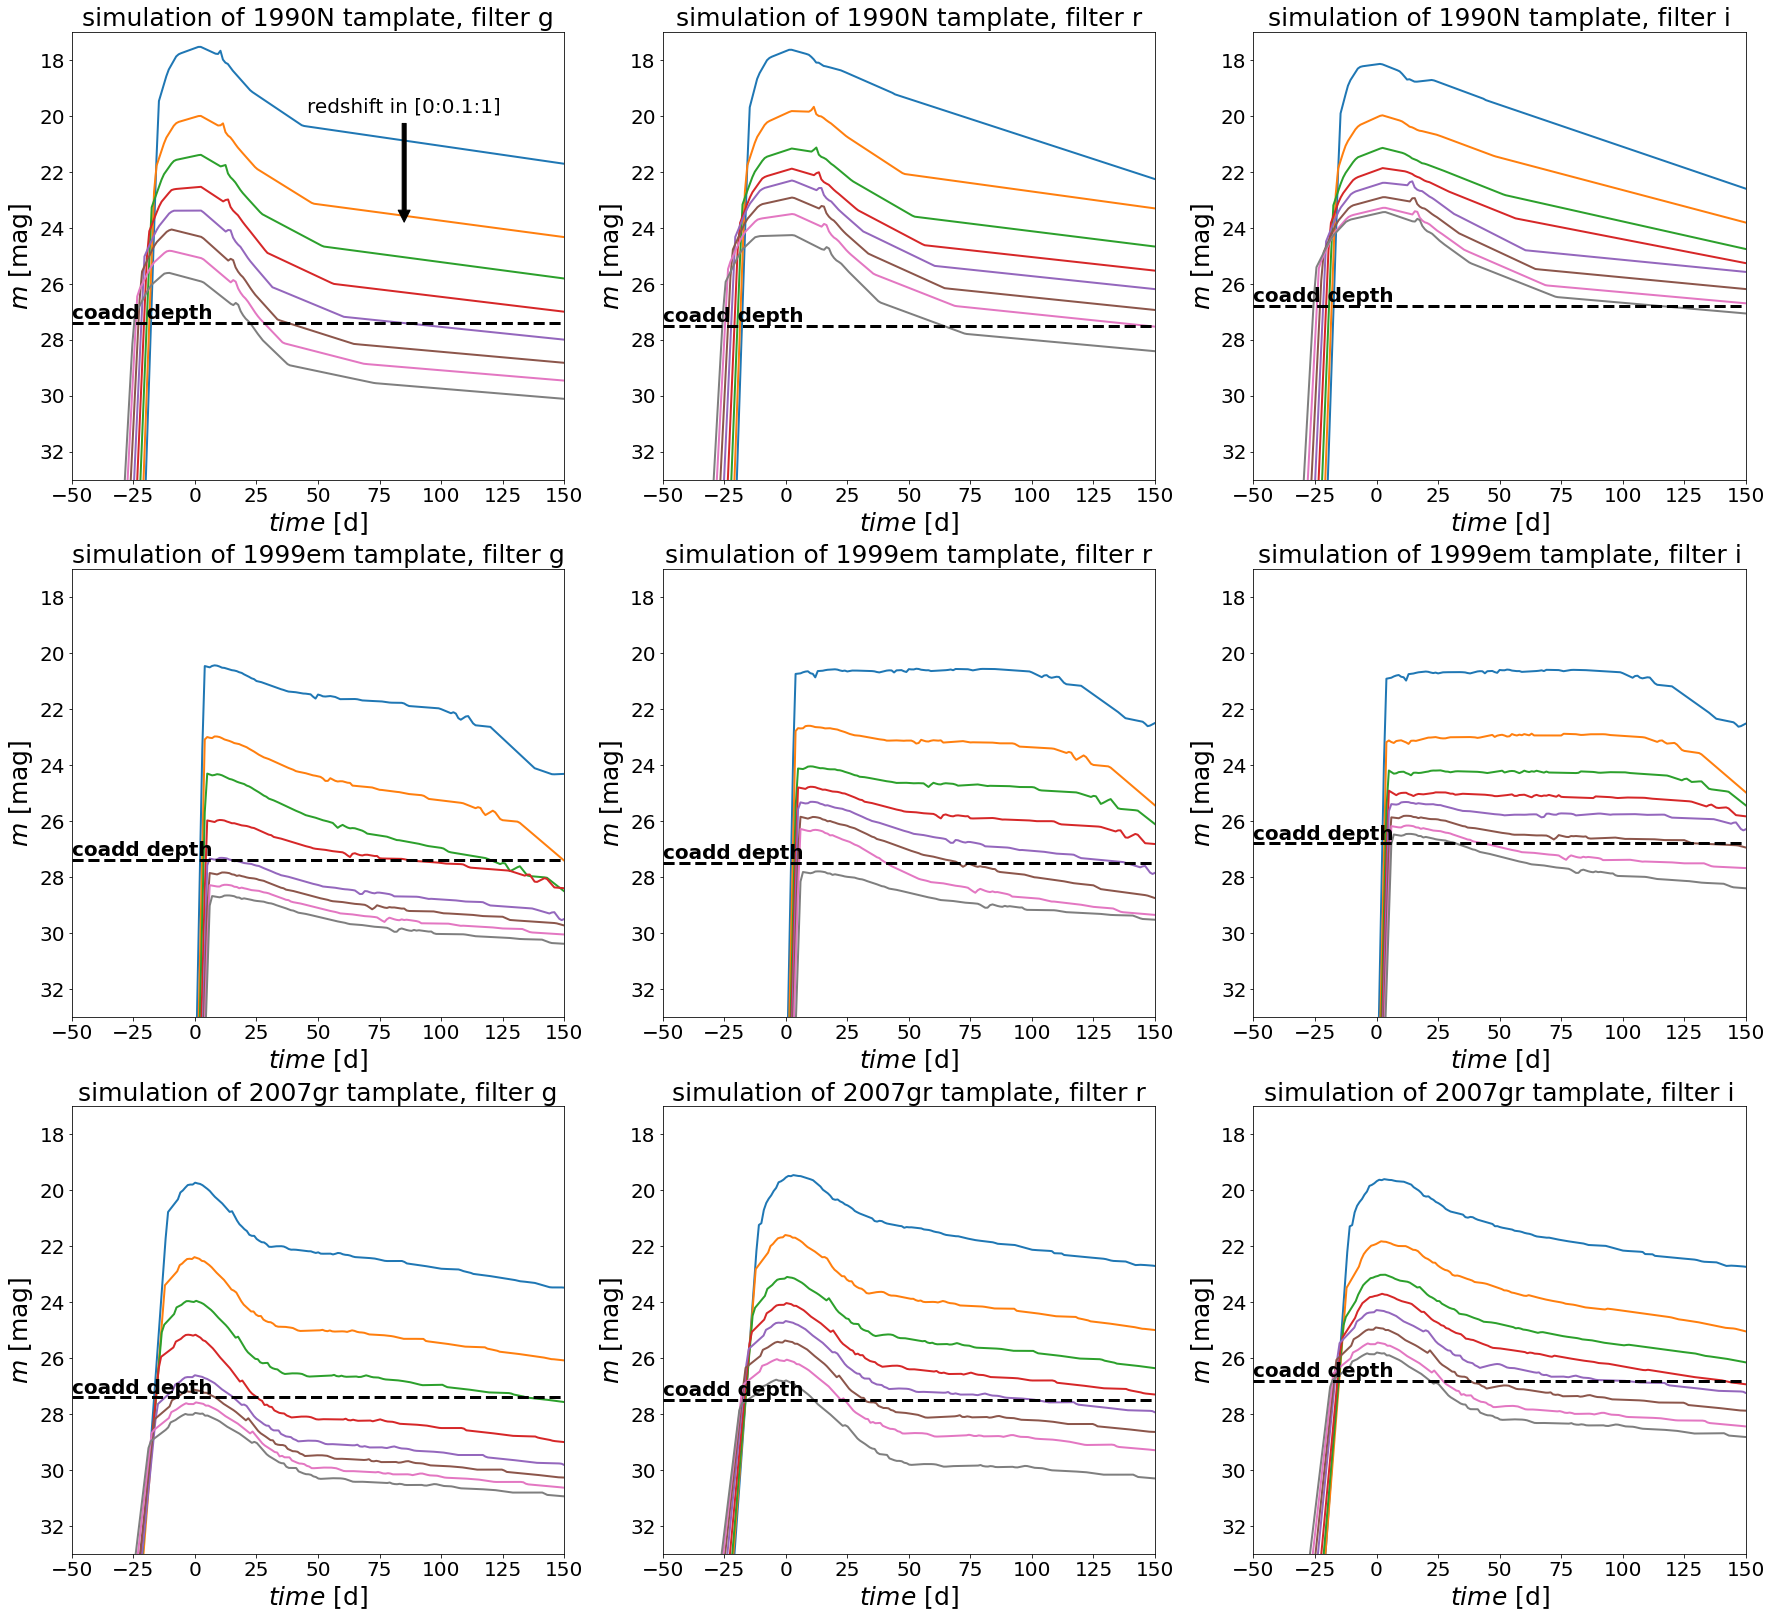

In [9]:
fig, axs = plt.subplots(3,3,figsize=(30,28))
for i, t in enumerate(['1990N','1999em','2007gr']):
    for j, f in enumerate(['g','r','i']):
        for z in obs_template['phobs'][t].keys():
            mag =obs_template['magobs'][t][z][f]
            ph = obs_template['phobs'][t][z][f]
            axs[i,j].plot(ph, mag,'-',lw=2)
        axs[i,j].invert_yaxis()
        if i==0 and j==0:
            axs[i,j].annotate('redshift in [0:0.1:1]',xy=(85, 24),xycoords='data',xytext=(85, 20), textcoords='data',fontsize=20,
                arrowprops=dict(facecolor='black', shrink=0.05),horizontalalignment='center', verticalalignment='bottom')
        axs[i,j].set_ylim([33,17])
        axs[i,j].set_xlim([-50,150])
        axs[i,j].set_xlabel(r'$time$ [d]',fontsize=25)
        axs[i,j].set_ylabel(r'$m$ [mag]',fontsize=25)
        axs[i,j].set_title(r'simulation of {} tamplate, filter {}'.format(t,f),fontsize=25)
        axs[i,j].tick_params('both', labelsize=20)
        if f == 'g':
            px,py = [-50,150],[27.4,27.4]
        elif f =='r':
            px,py=[-50,150],[27.5,27.5]
        elif f=='i':
            px,py = [-50,150],[26.8,26.8]
        axs[i,j].plot(px,py, 'k--', lw=3)
        axs[i,j].annotate('coadd depth',xy=(px[0],py[0]),xycoords='data',fontsize=20, weight='bold',
               horizontalalignment='left', verticalalignment='bottom')

These templates are then used to simulate SNe that explode during the survey. 

We set an array of explosion epochs that space uniformly the year of survey. 

In [10]:
expl_range=np.arange(0,365,10)
expl_range.size

37

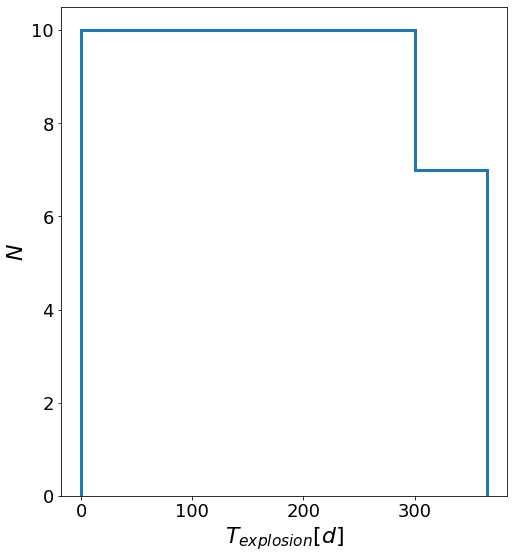

In [11]:
fig, ax=plt.subplots(1,figsize=(8,9))
ax.hist(expl_range, np.array([0,100,200,300,365]),histtype='step',linewidth=3,align='mid',label='Type Ia')
ax.set_xlabel(r'$T_{explosion}[d]$',fontsize=22)
ax.set_ylabel(r'$N$',fontsize=22)
ax.tick_params('both', labelsize=18)

### Extraction of the simulated observed light curve 

Once we have associated an explosion epoch to the light curves, we compare interpolate the magnitude values at the LSST observed epochs. 

In [12]:
import glob

workpath = os.getcwd()
os.chdir(dbDir)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()

In [13]:
dblist_all[0]

'baseline_nexp1_v1.7_10yrs.db'

In [14]:
dbname = dblist_all[0]
opsdb = db.OpsimDatabase(dbDir+dbname)
metric = getDataMetric(colname=['night', 'observationStartMJD', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter','visitExposureTime','visitTime'])
# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5  and proposalId > 1 for columns ['visitTime', 'fiveSigmaDepth', 'observationStartMJD', 'visitExposureTime', 'filter', 'fieldRA', 'fieldDec', 'night']
Found 5722 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [15]:
data = Sky.metricValues.data

# create DataFrame from ndarrays
df = pd.concat( [pd.DataFrame(d) for d in data], ignore_index=True, )

In [16]:
df

,visitTime,fiveSigmaDepth,observationStartMJD,visitExposureTime,filter,fieldRA,fieldDec,night
0,31.0,23.789254,60353.159656,30.0,i,150.353768,1.549694,500
1,31.0,23.515029,60372.110274,30.0,i,150.626169,2.642504,519
2,31.0,23.492588,60349.152259,30.0,r,150.553481,1.841210,496
3,31.0,23.425698,60349.152641,30.0,r,150.553481,1.841210,496
4,31.0,23.427100,60349.153023,30.0,r,150.553481,1.841210,496
...,...,...,...,...,...,...,...,...
3867,31.0,24.348909,60564.387244,30.0,r,63.088917,-47.553492,711
3868,31.0,24.348639,60564.387626,30.0,r,63.088917,-47.553492,711
3869,31.0,24.438800,60564.390787,30.0,r,63.088917,-47.553492,711
3870,31.0,24.438509,60564.391169,30.0,r,63.088917,-47.553492,711


To properly coadd the visits in the same night we operate some edits on the dataframe:

In [17]:
keygroup = ['filter', 'night']

df.sort_values(by=keygroup, ascending=[
                 True, True], inplace=True)

coadd_df = df.groupby(keygroup).agg({'visitExposureTime': ['sum'],
                                       'visitTime': ['sum'],
                                       'observationStartMJD': ['mean'],
                                       'fieldRA': ['mean'],
                                       'fieldDec': ['mean'],
                                       'fiveSigmaDepth': ['mean']}).reset_index()

coadd_df.columns = ['filter','night', 'visitExposureTime','visitTime',
                    'observationStartMJD', 'fieldRA', 'fieldDec',
                    'fiveSigmaDepth']

coadd_df.loc[:, 'fiveSigmaDepth'] += 1.25 * \
    np.log10(coadd_df['visitTime']/30.)

coadd_df.sort_values(by=['filter', 'night'], ascending=[
                     True, True], inplace=True)

In [18]:
coadd_df

,filter,night,visitExposureTime,visitTime,observationStartMJD,fieldRA,fieldDec,fiveSigmaDepth
0,g,368,300.0,310.0,60221.112796,8.970756,-44.017869,25.871821
1,g,369,300.0,310.0,60222.178553,35.343329,-4.956245,26.052102
2,g,370,300.0,310.0,60223.180467,53.125671,-28.682874,25.771225
3,g,372,300.0,310.0,60225.194087,35.350342,-4.816874,25.856232
4,g,374,1200.0,1240.0,60227.228782,52.848954,-32.746803,26.529350
...,...,...,...,...,...,...,...,...
166,r,713,600.0,620.0,60566.343662,35.327134,-5.092714,25.859743
167,r,723,600.0,620.0,60576.157742,9.536181,-44.244882,26.202778
168,r,725,600.0,620.0,60578.240291,36.344466,-4.475056,25.752712
169,r,727,1200.0,1240.0,60580.256669,49.478615,-26.404207,26.344076


To check if there are any observation during the period we simulate the ligh curve on we create a mask. To show an example we need to fix a template (here 1990N) a redshift (here z =0.1) and an explosion time.

In [19]:
lc= pd.DataFrame(obs_template['phobs']['1990N'][0.1])
obs = coadd_df['observationStartMJD']
times = expl_range[4] + coadd_df['observationStartMJD'].min()
transDuration = lc['g'].max() - lc['g'].min()
indexlc = np.where((obs>= times) & (obs<=times+transDuration))[0]
indexlc

array([ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142])

Then we use these idices to select the epochs to which we interpolate the lightcurve to estimate the megnitude at that observed epoch.

In [20]:
snclass=SNclassification_metric()
snclass.read_lightCurve('./template/snlc_1990N_z=0.1_DDF.ascii')

I'm reading the templates


In [21]:
lcEpoch = (obs[indexlc] - times)
sim_lc = SNclassification_metric.make_lightCurve(snclass,lcEpoch, coadd_df['filter'][indexlc])

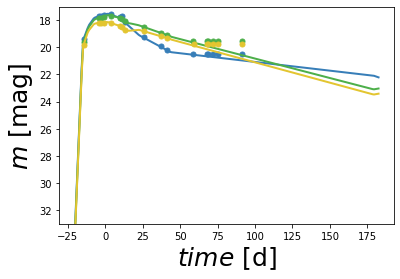

In [22]:
plt.figure()
for i, (f , c) in enumerate(zip(['g','r','i'],['#377eb8','#4daf4a', '#e3c530'])):
    filter_match = np.where(coadd_df['filter'][indexlc]==f)
    mag = obs_template['magobs']['1990N'][0.1][f]
    ph = obs_template['phobs']['1990N'][0.1][f]
    plt.plot(ph, mag,'-',lw=2, color=c)
    plt.plot(np.array(lcEpoch)[filter_match]-20,sim_lc[filter_match],'o',markersize=5, color =c)
    plt.gca().invert_yaxis()
    plt.ylim([33,17])
    plt.xlabel(r'$time$ [d]',fontsize=25)
    plt.ylabel(r'$m$ [mag]',fontsize=25)
    

### Filtering for the detected and classifiable SN

We estimate the SNR of the detections in the epochs of the interpolation.

In [23]:
lcSNR = m52snr(sim_lc, coadd_df['fiveSigmaDepth'][indexlc])
np.array(lcSNR)

array([ 1750.4871211 ,  4579.61721286,  8362.7901476 , 16444.85411996,
       12618.90767242,  5845.72859514, 10197.78130805,  5763.93120043,
         807.19498028,   841.06184651,  1199.15727309,   719.76928215,
         355.10243266,   738.57498912,   846.38961397,   501.65634997,
         742.77906707,   778.86453937,  2948.19518232,  3781.59370846,
        5256.25279215,  4743.85873818,  2318.71380179,  2900.40558496,
        1911.07090744,  1158.79001379,  1007.52526465,  1577.37278441,
         637.04677701,   470.27278927,   950.61237952,   998.29465696,
         637.15151026,   839.22071379,  1561.48431817,  6986.42725027,
        6182.51070281, 12340.9971496 , 12863.35651766,  8787.42280997,
        7610.19763599,  5672.28701519,  3169.37239797,  1496.21346622,
        2620.38340532,  1567.25011558,   881.60167225,  1740.12622112,
        1793.35710679,  1381.02714835,  1377.85410741])

Finally we compare the threshold we sat for the detection (SNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5})

We consider two different label for the light curve: detected and classifiable (labeled as filtered_class).

- detected: if the number of detection on the lightcurve in all filter is grater than 3;
- filtered_class: if the number of detection on the lightcurve in all filter, whitin the 30 days from the explosion, is grater than 5;

Only for those who pass the classifiable threshold we produce a file to inject in PSNID for the classification. 

In [24]:
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}
lcpoints_AboveThresh = np.zeros(len(lcSNR), dtype=bool) 
for f in ['g','r','i']:                    
        filtermatch = np.where(coadd_df['filter'][indexlc] == f)
        lcpoints_AboveThresh[filtermatch] = np.where(np.array(lcSNR)[filtermatch] >= detectSNR[f],True,False) 

In [25]:
lcpoints_AboveThresh

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

## PSNID

We finally save the classification results and build a confusion matrix.

It is worth to note that PSNID classify light curves as 'Ia','Ibc','II','UNKNOWN', we considered 'UKNOWN' as the light curve is unclassified.

In [35]:
r = subprocess.check_output([os.environ['SNANA_DIR']+'/bin/psnid.exe', os.environ['LSST_DIR']+'/PSNID_LSST__baseline_nexp1_v1.7_10yrs.nml'], stderr=subprocess.STDOUT)

# we search for classification flags in the variable r 
Ia=['1990N','1992A','1994D','2002bo','1991T','1999ee','1991bg','2000cx','2002cx']
Ibc=['2009jf','2008D','1994I','2004aw','2007gr','1998bw']
II=['1999em','2004et','2009bw','1999br','1999gi','2005cs','1992H','1993J','2008ax','1987A','2010jl','1998S','1997cy','2005gj','2008es']
  
line= np.array(r.split())
custom_split = np.vectorize(snclass.custom_split)
types = np.where(line==b'type')
sn_t = custom_split(x=line[np.where(line==b'Done')[0]+3],c='_',index=0)
z_t = custom_split(x=line[np.where(line==b'Done')[0]+3],c='_',index=1)
float_z = np.vectorize(float)
z_t = float_z(z_t)
z = np.unique(z_t)
CM = {zz: pd.DataFrame(columns= ['Ia','Ibc','II','UKNOWN'], index= ['Ia','Ibc','II']) for zz in z}

# confusion matrix
for zz in z:
    nClassified=0
    CM[zz]['Ia']['Ia']=0
    CM[zz]['Ibc']['Ia']=0
    CM[zz]['II']['Ia']=0
    CM[zz]['UKNOWN']['Ia']=0
    CM[zz]['Ia']['Ibc']=0
    CM[zz]['Ibc']['Ibc']=0
    CM[zz]['II']['Ibc']=0
    CM[zz]['UKNOWN']['Ibc']=0
    CM[zz]['Ia']['II']=0
    CM[zz]['Ibc']['II']=0
    CM[zz]['II']['II']=0
    CM[zz]['UKNOWN']['II']=0
    z_index = np.in1d(z_t,[zz])
    type_z= line[types[0]+2][z_index]
    sn_Ia= np.in1d(sn_t,Ia)[z_index]
    sn_Ibc= np.in1d(sn_t,Ibc)[z_index]
    sn_II= np.in1d(sn_t,II)[z_index]
    CM[zz]['Ia']['Ia']+=np.nansum(type_z[sn_Ia]==b'Ia')/(np.nansum(sn_Ia))
    CM[zz]['Ibc']['Ia']+=np.nansum(type_z[sn_Ia]==b'Ibc')/(np.nansum(sn_Ia))
    CM[zz]['II']['Ia']+=np.nansum(type_z[sn_Ia]==b'II')/(np.nansum(sn_Ia))
    CM[zz]['UKNOWN']['Ia']+=np.nansum(type_z[sn_Ia]==b'UNKNOWN')/(np.nansum(sn_Ia))
    CM[zz]['Ia']['Ibc']+=np.nansum(type_z[sn_Ibc]==b'Ia')/(np.nansum(sn_Ibc))
    CM[zz]['Ibc']['Ibc']+=np.nansum(type_z[sn_Ibc]==b'Ibc')/(np.nansum(sn_Ibc))
    CM[zz]['II']['Ibc']+=np.nansum(type_z[sn_Ibc]==b'II')/(np.nansum(sn_Ibc))
    CM[zz]['UKNOWN']['Ibc']+=np.nansum(type_z[sn_Ibc]==b'UNKNOWN')/(np.nansum(sn_Ibc))
    CM[zz]['Ia']['II']+=np.nansum(type_z[sn_II]==b'Ia')/(np.nansum(sn_II))
    CM[zz]['Ibc']['II']+=np.nansum(type_z[sn_II]==b'Ibc')/(np.nansum(sn_II))
    CM[zz]['II']['II']+=np.nansum(type_z[sn_II]==b'II')/(np.nansum(sn_II))
    CM[zz]['UKNOWN']['II']+=np.nansum(type_z[sn_II]==b'UNKNOWN')/(np.nansum(sn_II))
    CM[zz]=CM[zz].fillna(0)
     

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipyk

The confusion matrix is normalized with respect to the the number of classifiable light curves.

In [36]:
[[print('z= '+str(k)),print(CM[k])] for k in CM.keys()] 
                

z= 0.1
      Ia  Ibc   II  UKNOWN
Ia   1.0  0.0  0.0     0.0
Ibc  0.0  0.0  0.0     0.0
II   0.0  0.0  0.0     0.0
z= 0.4
      Ia  Ibc   II  UKNOWN
Ia   1.0  0.0  0.0     0.0
Ibc  0.0  0.0  0.0     0.0
II   0.0  0.0  0.0     0.0
z= 0.7
      Ia  Ibc   II  UKNOWN
Ia   1.0  0.0  0.0     0.0
Ibc  0.0  0.0  0.0     0.0
II   0.0  0.0  0.0     0.0


[[None, None], [None, None], [None, None]]

### Example of the metric using the MAF


The algorithm expose up to now is repeted over all the footprint throught the MAF. 

In [ ]:
sngroupsIa ={'Ia':{'Ia':(['1991T'],100)}}
expl_range=np.arange(0,365,10)
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_parallel_v1.7'.format(your_username)
process = []
import multiprocessing as mp
start_time = time.time()
for run in ['baseline_nexp1_v1.7_10yrs']:
    metriclcIa = SNclassification_metric_DDF(z=[0.1,0.9,0.3], metricName='Ia_DDF_test',LCfolder='./LC_{}'.format(run), mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              surveyDuration=surveyDuration, \
                              templates= sngroupsIa, explosiontime=expl_range,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, \
                              ndetect=3,nclass=5,dataout=True)
    metriclc_trans_Ia= metricBundles.MetricBundle(metriclcIa, slicer, sqlconstraint_DDF, metadata='DDF only')
    bundleDict={'Ia_DDF_test':metriclc_trans_Ia}

    warnings.filterwarnings('ignore')
    metriclc_trans_Ia.setRunName(run)
    #metriclc_get_Colmetric.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    p=mp.Process(target=bgrouplc.runAll)
    p.start()
    process.append(p)
for pr in process:
    pr.join()    
print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
print('####################\n')

In [38]:

metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_parallel_v1.7'.format(your_username)
resultDbs = getResultsDbs(metricDataPath)
# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in ['baseline_nexp1_v1.7_10yrs']:#,dbRuns[29]]:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [39]:
df17={}
coo_df={}
for opsim in  ['baseline_nexp1_v1.7_10yrs']:#,'baseline_nexp2_v1.7_10yrs']:
    df17[opsim]={}
    coo_df[opsim]={}
    
    bmetric =[(2, '_baseline_nexp1_v1.7_10yrs'), (3, 'get_Col')]
    for metric in bmetric:#, (4, 'II'), (5, 'Ibc')]:
        coo_df[opsim][metric[1]] = np.column_stack((bundleDicts[opsim][metric].slicer.slicePoints['ra'][np.where(bundleDicts[opsim][metric].metricValues.mask==False)]
                                          ,bundleDicts[opsim][metric].slicer.slicePoints['dec'][np.where(bundleDicts[opsim][metric].metricValues.mask==False)]))
        arr=bundleDicts[opsim][metric].metricValues.data
        arr_=arr[np.where(arr!=None)]
        df17[opsim][metric[1]] = pd.DataFrame.from_records(arr_)

## Observed light curve from the opsim 

In [40]:
lc_list = glob.glob('LC_DDF/*dat')
lc_list[10:20]

obs={l:{}for l in lc_list}
coo = {l:[]for l in lc_list}
expl = []
for lobs in obs.keys():
    expl.append(float(lobs.split('_')[-2]))
    f= open(lobs,'r')
    r= f.read()
    l =r.split('\n')
    idx_z = np.where(np.array(l)=='REDSHIFT_FINAL:  0.1 +- 0.700 (CMB)')
    loc = l[3].split()
    ra = float(loc[1])
    loc = l[4].split()
    dec = float(loc[1])
    coo[lobs].append([ra,dec])    
    z=float(np.array(r.split('\n'))[6].split()[1])
    idx_in = np.where(np.array(l)=='VARLIST:  MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR ')
    idx_end= np.where(np.array(l)=='END: ')
    e_obs,m_obs,err_obs,f_obs=[],[],[],[]
    for i in np.arange(idx_in[0][0]+1,idx_end[0][0],1):
        e_obs.append(float(l[i].split()[1]))
        m_obs.append(float(l[i].split()[-2]))
        err_obs.append(float(l[i].split()[-1]))
        f_obs.append(l[i].split()[2])
    obs[lobs].update({z:{'epoch':np.array(e_obs),
                      'mag':np.array(m_obs),
                      'mag_err':np.array(err_obs),'filter':np.array(f_obs),'coo': [ra,dec]}})
    

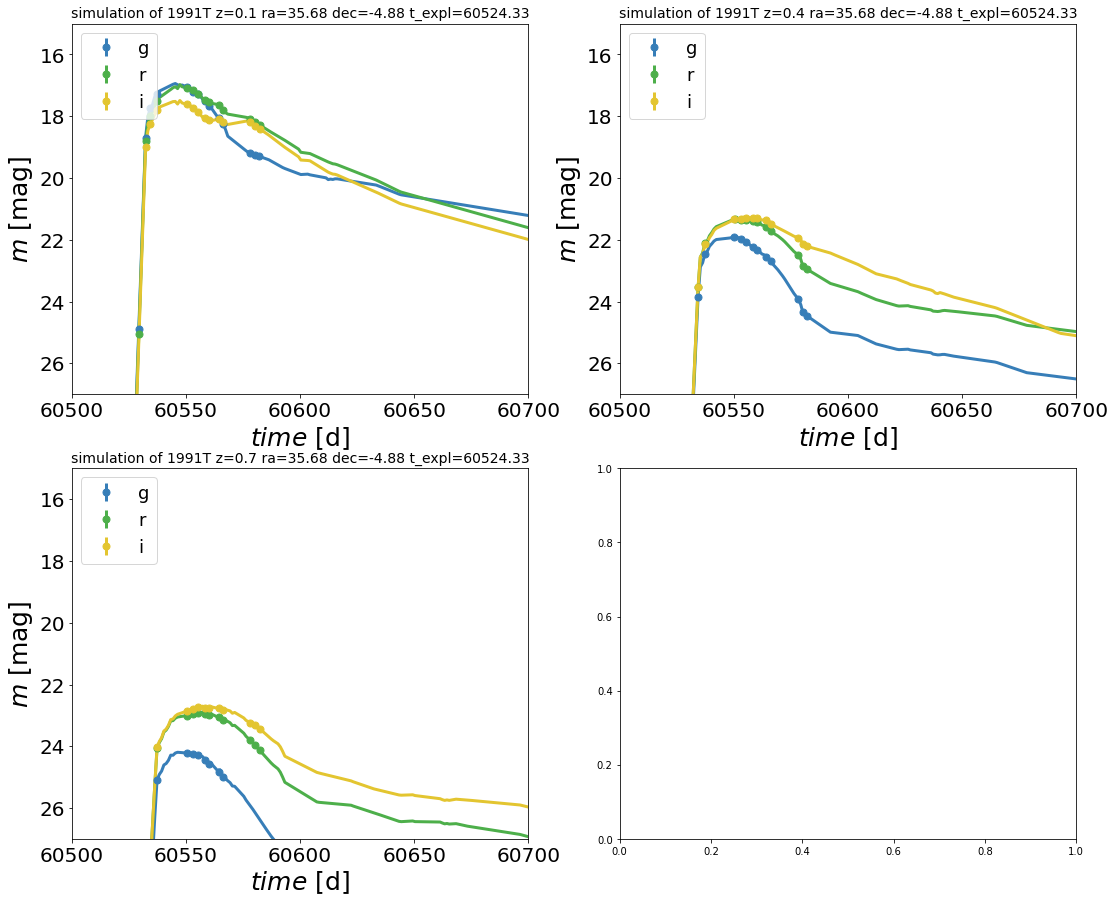

In [33]:
llist=['LC_DDF/LSST_1991T_0.1_60524.33_DDF.dat','LC_DDF/LSST_1991T_0.4_60524.33_DDF.dat','LC_DDF/LSST_1991T_0.7_60524.33_DDF.dat']ObsStart= df17['baseline_nexp1_v1.7_10yrs']['get_Col']['observationStartMJD'][1].min()

ObsStart= df17['baseline_nexp1_v1.7_10yrs']['get_Col']['observationStartMJD'][1].min()
color = ['#377eb8','#4daf4a', '#e3c530']
fig, axes = plt.subplots(2,2,figsize=(18,15))
for i,axs in enumerate(axes.flatten()[0:3]):
    for j, f in enumerate(['g','r','i']):
        c=color[j]
        t_expl = float(llist[i].split('_')[-2])
        z = float(llist[i].split('_')[3])
        filters=obs[llist[i]][z]['filter']==f
        mag =obs_template['magobs']['1991T'][z][f]
        maglc =obs[llist[i]][z]['mag'][filters]
        magerrlc =obs[llist[i]][z]['mag_err'][filters]
        
        if np.size(obs[llist[i]][z]['epoch'][filters])>0:
            ph = obs_template['phobs']['1991T'][z][f]-obs_template['phobs']['1991T'][z][f][mag==max(mag)]+t_expl
            phlc = obs[llist[i]][z]['epoch'][filters]#-obs[llist[i]][z]['epoch'][filters][0]+e[i]
            axs.errorbar(phlc, maglc,yerr=magerrlc,fmt='o',elinewidth=3,color=c,markersize=7,label=f)
            axs.plot(ph, mag,'-',lw=3,color=c)
        axs.invert_yaxis()
        axs.set_ylim([27,15])
        axs.set_xlim([60500,60700])
        axs.set_xlabel(r'$time$ [d]',fontsize=25)
        axs.set_ylabel(r'$m$ [mag]',fontsize=25)
        axs.set_title(r'simulation of 1991T z={} ra={} dec={} t_expl={}'.format(z,
        np.round(obs[llist[i]][z]['coo'][0],2),np.round(obs[llist[i]][z]['coo'][1],2), t_expl),fontsize=14)
        axs.tick_params('both', labelsize=20)
    #if i ==0:
        axs.legend(loc=2,fontsize=18)
plt.savefig('./lc_example.pdf')

## Skymap 

In the following some analysis that can be done on the output data.

In [ ]:
fractions={'Ia':None,'II':None,'Ibc':None}

for j, key in enumerate(fractions.keys()):
    c = np.zeros(np.size(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class']))
    for l,k in enumerate(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index):
        o=[]
        
        for i in range(len(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'])):
            
            o.append(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][i][k][key][key])
            
        
        c+=np.array(o)
        
    fractions[key]=c/3

In [ ]:
detected = []

for i in range(len(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'])):

    det=0
    for l,k in enumerate(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index):
        det+=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['Detected']/(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['Detected']+
        df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['UnDetected'])

    detected.append(det/3)

In [ ]:
zfractions={'Ia':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index},
            'II':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index},
            'Ibc':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index}}
for j, key in enumerate(fractions.keys()):
    c = np.zeros(np.size(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class']))
    for l,k in enumerate(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index):
        for i in range(len(c)):
            #for i in range(len(df17['baseline_nexp1_v1.7_10yrs']['Ia_DDF']['class'])):
            c[i]=(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nFiltered']['filtered_class'])/(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['Detected']+
        df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['UnDetected'])
        zfractions[key][k]=np.array(c)

Skymap of the number of visits

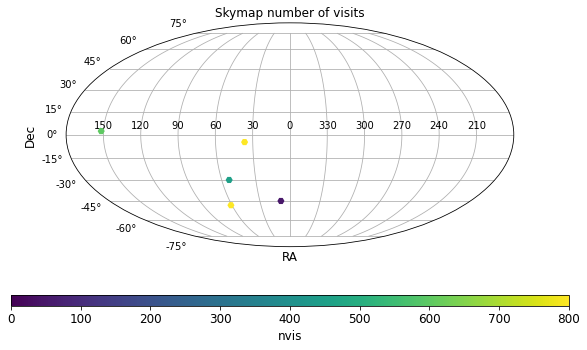

In [47]:
fig=plt.figure(figsize=(10,20))
for i, key in enumerate(['Ia']):
        ax= fig.add_subplot(3,1,j+1, projection='mollweide')
        plt_mlw(ax,ra_,dec_,c=nvis,vmin=0,vmax=800,dicts={'marker':'H','cbartitle':'nvis','colormap':'viridis','title': 'Skymap number of visits','psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')

Skymap of fraction of correctly classified SNe

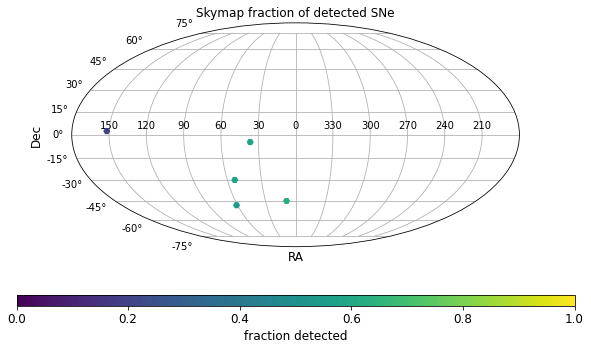

In [48]:
fig=plt.figure(figsize=(10,20))
for i, key in enumerate(['Ia']):
        ax= fig.add_subplot(3,1,j+1, projection='mollweide')
        plt_mlw(ax,ra_,dec_,c=detected,vmin=0,vmax=1,dicts={'marker':'H','cbartitle':'fraction detected','colormap':'viridis','title': 'Skymap fraction of detected SNe','psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')

Skymap of $\frac{(\text{number of filtered SNe for the classification})}{(\text{number of simulated SNe})}$  

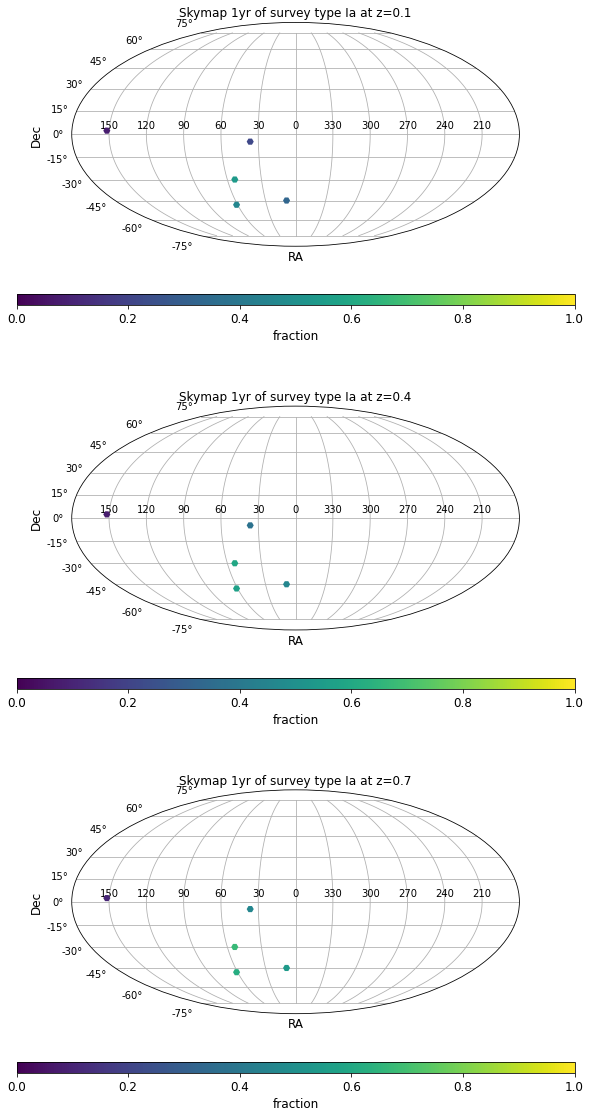

In [49]:
fig=plt.figure(figsize=(10,20))
for i, key in enumerate(['Ia']):
    for j, z in enumerate([0.1,0.4,0.7]):
        ax= fig.add_subplot(3,1,j+1, projection='mollweide')
        plt_mlw(ax,ra_,dec_,c=zfractions[key][z],vmin=0,vmax=1,dicts={'marker':'H','cbartitle':'fraction','colormap':'viridis','title': 'Skymap 1yr of survey type {} at z={}'.format(key,z),'psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')